# MERL

In [1]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt
import os
import math
from copy import deepcopy
from typing import Tuple
import pandas as pd
from openpyxl import Workbook

# ==========================
# System parameters
# ==========================

c = 3e8
fc = 28e9
lam = c / fc
alpha_const = c / (4 * np.pi * fc)

n_eff = 1.4
lam0 = lam / n_eff

sigma2_dBm = -90
sigma2 = 10 ** ((sigma2_dBm - 30) / 10.0)

Gamma_th_dB = 10
Gamma_th = 10 ** (Gamma_th_dB / 10.0)

delta_min = lam / 2.0

M = 6
N_pinching = 3
K = 1

T_slots = 15
Delta_t = 1.0

d_ant_height = 3.0
pin_feed_point_x = 0.0

AREA_MAX_X = 150.0
AREA_MAX_Y = 150.0

P0_dBm = 20.0
P0_max = 10 ** ((P0_dBm - 30) / 10.0)

E_max = 6.0

UE_positions = np.array([
    [33.6309,  89.9410, 0.0],
    [39.6081,  17.1488, 0.0],
    [146.6042, 121.5036, 0.0],
    [148.9406, 34.7796, 0.0],
    [149.2488, 148.6565, 0.0],
    [85.7213,  82.8948, 0.0],
], dtype=np.float64)

Target_positions = np.array([
    [65.8152, 13.0490, 0.0],
], dtype=np.float64)


def project_positions_min_spacing(pos, delta, x_max):
    N = len(pos)
    idx = np.argsort(pos)
    p_sorted = np.clip(pos[idx], 0.0, x_max)

    for i in range(1, N):
        if p_sorted[i] - p_sorted[i - 1] < delta:
            p_sorted[i] = p_sorted[i - 1] + delta

    for i in range(N - 2, -1, -1):
        if p_sorted[i + 1] - p_sorted[i] < delta:
            p_sorted[i] = p_sorted[i + 1] - delta

    p_sorted = np.clip(p_sorted, 0.0, x_max)

    proj = np.zeros_like(pos)
    proj[idx] = p_sorted
    return proj


def compute_rate_and_snr_slot(p_m_t, x_pin_t):
    epsd = 1e-9

    pin_pos = np.vstack([
        x_pin_t,
        np.zeros(N_pinching),
        d_ant_height * np.ones(N_pinching),
    ])

    dist_from_feed = np.abs(x_pin_t - pin_feed_point_x)
    theta_n = 2 * np.pi * dist_from_feed / lam0

    total_rate = 0.0
    Hm_vals = np.zeros(M, dtype=np.complex128)

    for m in range(M):
        user_pos = UE_positions[m, :].reshape(3, 1)
        dist_mn = np.linalg.norm(user_pos - pin_pos, axis=0) + epsd

        H_m = np.sum(
            alpha_const
            * np.exp(-1j * 2 * np.pi / lam * dist_mn) / dist_mn
            * np.exp(-1j * theta_n)
        )
        Hm_vals[m] = H_m

        p_m = p_m_t[m]
        R_m = (1.0 / M) * np.log2(1.0 + (np.abs(H_m) ** 2 * p_m) / (N_pinching * sigma2))
        total_rate += np.real(R_m)

    SNR_targets = np.zeros(K)
    for k in range(K):
        tgt_pos = Target_positions[k, :].reshape(3, 1)
        dist_kn = np.linalg.norm(tgt_pos - pin_pos, axis=0) + epsd

        H_k = np.sum(
            alpha_const
            * np.exp(-1j * 2 * np.pi / lam * dist_kn) / dist_kn
            * np.exp(-1j * theta_n)
        )

        SNR_m = np.zeros(M)
        for m in range(M):
            p_m = p_m_t[m]
            num = np.abs(H_k) ** 2 * p_m / N_pinching
            denom = np.abs(Hm_vals[m]) ** 2 * p_m / N_pinching + sigma2
            SNR_m[m] = num / denom

        SNR_targets[k] = np.max(SNR_m)

    return total_rate, SNR_targets


class PinchingISACEnv(gym.Env):
    metadata = {"render.modes": []}

    def __init__(self, beta_snr=1.0):
        super().__init__()

        self.beta_snr = beta_snr
        self.max_time = T_slots
        self.area_x = AREA_MAX_X

        obs_dim = (
            1 + 1 + N_pinching + M * 3 + K * 3
        )

        self.action_dim = N_pinching + M

        self.observation_space = spaces.Box(
            low=-np.ones(obs_dim, dtype=np.float32),
            high=np.ones(obs_dim, dtype=np.float32),
            dtype=np.float32,
        )

        self.action_space = spaces.Box(
            low=-np.ones(self.action_dim, dtype=np.float32),
            high=np.ones(self.action_dim, dtype=np.float32),
            dtype=np.float32,
        )

        self._ue_flat = UE_positions.reshape(-1)
        self._tgt_flat = Target_positions.reshape(-1)

        self.reset()

    def reset(self):
        self.t = 0
        self.energy_used = 0.0

        base_lin = np.linspace(10.0, self.area_x - 10.0, N_pinching)
        xpin0 = base_lin + np.random.randn(N_pinching) * 1.0
        xpin0 = np.clip(xpin0, 0.0, self.area_x)
        xpin0 = project_positions_min_spacing(xpin0, delta_min, self.area_x)
        self.x_pin_t = xpin0.copy()

        return self._get_obs()

    def _get_obs(self):
        time_norm = self.t / (self.max_time - 1.0)
        energy_remaining = max(E_max - self.energy_used, 0.0)
        energy_norm = energy_remaining / E_max
        xpin_norm = self.x_pin_t / self.area_x

        obs = np.concatenate([
            np.array([time_norm], dtype=np.float64),
            np.array([energy_norm], dtype=np.float64),
            xpin_norm.astype(np.float64),
            self._ue_flat,
            self._tgt_flat,
        ])

        obs_mapped = 2.0 * obs - 1.0
        return obs_mapped.astype(np.float32)

    def step(self, action):
        action = np.clip(action, -1.0, 1.0)
        a_x = action[:N_pinching]
        a_p = action[N_pinching:]

        x_pin_t = (a_x + 1.0) / 2.0 * self.area_x
        x_pin_t = project_positions_min_spacing(x_pin_t, delta_min, self.area_x)

        p_m_t = (a_p + 1.0) / 2.0 * P0_max

        total_power = np.sum(p_m_t)
        remaining_energy = E_max - self.energy_used
        max_power_sum = remaining_energy / Delta_t

        if total_power * Delta_t > remaining_energy and total_power > 1e-9:
            scale = max_power_sum / total_power
            p_m_t = p_m_t * scale
            total_power = np.sum(p_m_t)

        slot_rate, snr_targets = compute_rate_and_snr_slot(p_m_t, x_pin_t)
        Gamma_k_t = float(snr_targets[0])

        reward = slot_rate + self.beta_snr * (Gamma_k_t - Gamma_th)

        self.x_pin_t = x_pin_t
        self.energy_used += total_power * Delta_t
        self.t += 1

        done = False
        if self.t >= self.max_time:
            done = True
        if self.energy_used >= E_max - 1e-6:
            done = True

        obs = self._get_obs()

        info = {
            "slot_rate": slot_rate,
            "slot_snr": Gamma_k_t,
            "energy_used": self.energy_used,
            "x_pin": x_pin_t.copy(),
            "p_m": p_m_t.copy(),
        }

        return obs, float(reward), done, info

    def render(self, mode="human"):
        pass


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class GaussianPolicy(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.mean_layer = nn.Linear(hidden_dim, act_dim)
        self.log_std_layer = nn.Linear(hidden_dim, act_dim)

        self.LOG_STD_MIN = -20.0
        self.LOG_STD_MAX = 2.0

    def forward(self, obs):
        x = self.net(obs)
        mean = self.mean_layer(x)
        log_std = self.log_std_layer(x)
        log_std = torch.clamp(log_std, self.LOG_STD_MIN, self.LOG_STD_MAX)
        return mean, log_std

    def sample(self, obs):
        mean, log_std = self.forward(obs)
        std = torch.exp(log_std)
        normal = torch.distributions.Normal(mean, std)
        z = normal.rsample()
        action = torch.tanh(z)
        log_prob = normal.log_prob(z) - torch.log(1.0 - action.pow(2) + 1e-6)
        log_prob = log_prob.sum(dim=-1, keepdim=True)
        return action, log_prob

    def deterministic(self, obs):
        mean, _ = self.forward(obs)
        action = torch.tanh(mean)
        return action


class QNetwork(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim + act_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, obs, act):
        x = torch.cat([obs, act], dim=-1)
        return self.net(x)


class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def push(self, s, a, r, s_next, done):
        self.buffer.append((s, a, r, s_next, float(done)))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, s_next, d = map(np.array, zip(*batch))
        return (
            torch.tensor(s, dtype=torch.float32, device=device),
            torch.tensor(a, dtype=torch.float32, device=device),
            torch.tensor(r, dtype=torch.float32, device=device).unsqueeze(-1),
            torch.tensor(s_next, dtype=torch.float32, device=device),
            torch.tensor(d, dtype=torch.float32, device=device).unsqueeze(-1),
        )

    def __len__(self):
        return len(self.buffer)


class MERLAgent:
    def __init__(
        self,
        obs_dim,
        act_dim,
        gamma=0.99,
        rho=0.2,
        lr=1e-5,
        tau=0.005,
        buffer_size=500_000,
        batch_size=256,
    ):
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.gamma = gamma
        self.rho = rho
        self.tau = tau
        self.batch_size = batch_size

        self.policy = GaussianPolicy(obs_dim, act_dim).to(device)
        self.q1 = QNetwork(obs_dim, act_dim).to(device)
        self.q2 = QNetwork(obs_dim, act_dim).to(device)

        self.q1_target = QNetwork(obs_dim, act_dim).to(device)
        self.q2_target = QNetwork(obs_dim, act_dim).to(device)

        self.q1_target.load_state_dict(self.q1.state_dict())
        self.q2_target.load_state_dict(self.q2.state_dict())

        self.policy_opt = optim.Adam(self.policy.parameters(), lr=lr)
        self.q1_opt = optim.Adam(self.q1.parameters(), lr=lr)
        self.q2_opt = optim.Adam(self.q2.parameters(), lr=lr)

        self.replay = ReplayBuffer(buffer_size)

    def select_action(self, obs_np, deterministic=False):
        obs = torch.tensor(obs_np, dtype=torch.float32, device=device).unsqueeze(0)
        if deterministic:
            with torch.no_grad():
                a = self.policy.deterministic(obs)
        else:
            with torch.no_grad():
                a, _ = self.policy.sample(obs)
        return a.cpu().numpy()[0]

    def update(self):
        if len(self.replay) < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.replay.sample(self.batch_size)

        with torch.no_grad():
            next_actions, next_log_probs = self.policy.sample(next_states)

            q1_next = self.q1_target(next_states, next_actions)
            q2_next = self.q2_target(next_states, next_actions)
            q_next_min = torch.min(q1_next, q2_next)

            y = rewards + self.gamma * (1.0 - dones) * (
                q_next_min - self.rho * next_log_probs
            )

        q1_pred = self.q1(states, actions)
        q2_pred = self.q2(states, actions)

        q1_loss = nn.MSELoss()(q1_pred, y)
        q2_loss = nn.MSELoss()(q2_pred, y)
        q_loss = q1_loss + q2_loss

        self.q1_opt.zero_grad()
        self.q2_opt.zero_grad()
        q_loss.backward()
        self.q1_opt.step()
        self.q2_opt.step()

        new_actions, log_probs = self.policy.sample(states)
        q1_new = self.q1(states, new_actions)
        q2_new = self.q2(states, new_actions)
        q_new_min = torch.min(q1_new, q2_new)

        policy_loss = (self.rho * log_probs - q_new_min).mean()

        self.policy_opt.zero_grad()
        policy_loss.backward()
        self.policy_opt.step()

        with torch.no_grad():
            for param, target_param in zip(self.q1.parameters(), self.q1_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)
            for param, target_param in zip(self.q2.parameters(), self.q2_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)
def train_merl(
    num_episodes=2000,
    max_steps_per_episode=T_slots,
    beta_snr=1.0,
    rho=0.2,
    lr=1e-5,
    log_interval=10,
):
    env = PinchingISACEnv(beta_snr=beta_snr)
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]

    agent = MERLAgent(
        obs_dim=obs_dim,
        act_dim=act_dim,
        gamma=0.99,
        rho=rho,
        lr=lr,
        tau=0.01,
        buffer_size=500_000,
        batch_size=256,
    )

    # ===========================
    # ---- STORAGE ARRAYS -----
    # ===========================
    episode_rewards = []
    episode_snr = []
    episode_rate = []

    # OPTIONAL: STORE EACH STEP
    all_step_rewards = []
    all_step_snrs = []
    all_step_rates = []

    for ep in range(num_episodes):
        obs = env.reset()
        ep_reward = 0.0
        snr_list = []
        rate_list = []

        for step in range(max_steps_per_episode):
            action = agent.select_action(obs, deterministic=False)
            next_obs, reward, done, info = env.step(action)

            agent.replay.push(obs, action, reward, next_obs, done)
            agent.update()

            obs = next_obs

            # ---- Store step values ----
            all_step_rewards.append(reward)
            all_step_snrs.append(info["slot_snr"])
            all_step_rates.append(info["slot_rate"])

            ep_reward += reward
            snr_list.append(info["slot_snr"])
            rate_list.append(info["slot_rate"])

            if done:
                break

        # ---- Store episode aggregated values ----
        episode_rewards.append(ep_reward)
        episode_snr.append(np.mean(snr_list))
        episode_rate.append(np.mean(rate_list))

        if (ep + 1) % log_interval == 0:
            print(
                f"Episode {ep + 1} | "
                f"Reward {np.mean(episode_rewards[-log_interval:]):.3f} | "
                f"SNR {np.mean(episode_snr[-log_interval:]):.3f} | "
                f"Rate {np.mean(episode_rate[-log_interval:]):.3f}"
            )

    # ===========================================
    # ---------- SAVE TO EXCEL FILE -------------
    # ===========================================

    df_reward = pd.DataFrame({"Reward": episode_rewards})
    df_snr = pd.DataFrame({"SNR": episode_snr})
    df_rate = pd.DataFrame({"Rate": episode_rate})

    with pd.ExcelWriter("MERL_results.xlsx", engine="openpyxl") as writer:
        df_reward.to_excel(writer, sheet_name="EpisodeReward", index=True)
        df_snr.to_excel(writer, sheet_name="EpisodeSNR", index=True)
        df_rate.to_excel(writer, sheet_name="EpisodeRate", index=True)

    print("✔ Results saved to MERL_results.xlsx")

    return agent, episode_rewards, episode_snr, episode_rate


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ======== Plotting with Shadow (mean ± std) ========
def plot_reward_shadow(all_rewards):
    """
    all_rewards: list of lists, shape = [num_runs][num_episodes]
    """
    all_rewards = np.array(all_rewards)
    mean_curve = np.mean(all_rewards, axis=0)
    std_curve = np.std(all_rewards, axis=0)
    episodes = np.arange(len(mean_curve))

    plt.figure(figsize=(8, 5))

    # Light plots for each run
    for r in range(all_rewards.shape[0]):
        plt.plot(all_rewards[r], color="gray", alpha=0.35, linewidth=1)

    # Shadow region (±1 std)
    plt.fill_between(
        episodes,
        mean_curve - std_curve,
        mean_curve + std_curve,
        color="blue",
        alpha=0.2,
        label="Std. Dev."
    )

    # Thick mean curve
    plt.plot(
        episodes,
        mean_curve,
        color="blue",
        linewidth=2.5,
        label="Mean Reward"
    )

    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("MERL Training – 5 Runs (Mean ± Std)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# ======== MAIN: run MERL 5 times and plot shadow ========
if __name__ == "__main__":

    NUM_RUNS = 1
    NUM_EPISODES = 2000

    all_rewards = []

    for r in range(NUM_RUNS):
        print(f"\n==========================")
        print(f"   MERL TRAINING RUN {r+1}")
        print(f"==========================")

        agent_merl, rew_merl, snr_merl = train_merl(
            num_episodes=NUM_EPISODES,
            beta_snr=1.0,
            rho=0.2,
            lr=1e-5,
        )

        all_rewards.append(rew_merl)

    # Shadow plot of all runs
    plot_reward_shadow(all_rewards)


# TD3

In [ ]:
# ==============================
# Your full TD3 implementation
# (UNCHANGED)
# ==============================

import os
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from copy import deepcopy
from typing import Tuple

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Actor(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, act_dim),
            nn.Tanh()
        )
    def forward(self, obs):
        return self.net(obs)

class Critic(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim + act_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )
    def forward(self, obs, act):
        x = torch.cat([obs, act], dim=-1)
        return self.net(x)

class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
    def push(self, s, a, r, s_next, done):
        self.buffer.append((s, a, r, s_next, float(done)))
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, s_next, d = map(np.array, zip(*batch))
        return (
            torch.tensor(s, dtype=torch.float32, device=device),
            torch.tensor(a, dtype=torch.float32, device=device),
            torch.tensor(r, dtype=torch.float32, device=device).unsqueeze(-1),
            torch.tensor(s_next, dtype=torch.float32, device=device),
            torch.tensor(d, dtype=torch.float32, device=device).unsqueeze(-1),
        )
    def __len__(self):
        return len(self.buffer)

class OUNoise:
    def __init__(self, action_dimension, mu=0, theta=0.15, sigma=0.2):
        self.action_dimension = action_dimension
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.action_dimension) * self.mu
        self.reset()
    def reset(self):
        self.state = np.ones(self.action_dimension) * self.mu
    def sample(self):
        x = self.state
        dx = self.theta*(self.mu - x) + self.sigma*np.random.randn(len(x))
        self.state = x + dx
        return self.state

class TwinCritic(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_dim=256):
        super().__init__()
        self.q1 = Critic(obs_dim, act_dim, hidden_dim)
        self.q2 = Critic(obs_dim, act_dim, hidden_dim)
    def forward(self, obs, act):
        return self.q1(obs, act), self.q2(obs, act)

class TD3Agent:
    def __init__(
        self,
        obs_dim,
        act_dim,
        actor_lr=1e-6,
        critic_lr=5e-4,
        gamma=0.99,
        tau=0.005,
        buffer_size=500_000,
        batch_size=256,
        hidden_dim=256,
        policy_noise=0.2,
        noise_clip=0.5,
        policy_delay=2,
        exploration_noise=0.1,
        use_ou=False,
    ):
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size

        self.actor = Actor(obs_dim, act_dim, hidden_dim).to(device)
        self.actor_target = deepcopy(self.actor).to(device)

        self.critic = TwinCritic(obs_dim, act_dim, hidden_dim).to(device)
        self.critic_target = TwinCritic(obs_dim, act_dim, hidden_dim).to(device)

        self.critic_target.q1.load_state_dict(self.critic.q1.state_dict())
        self.critic_target.q2.load_state_dict(self.critic.q2.state_dict())

        self.actor_opt = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_opt = optim.Adam(
            list(self.critic.q1.parameters()) + list(self.critic.q2.parameters()),
            lr=critic_lr,
        )

        self.replay = ReplayBuffer(buffer_size)
        self.use_ou = use_ou
        if use_ou:
            self.ou = OUNoise(act_dim, sigma=exploration_noise)
        else:
            self.ou = None
        self.exploration_noise = exploration_noise

        self.policy_noise = policy_noise
        self.noise_clip = noise_clip
        self.policy_delay = policy_delay
        self.total_it = 0

    def select_action(self, obs, noise=True):
        obs_t = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            a = self.actor(obs_t).cpu().numpy()[0]
        if noise:
            if self.use_ou and self.ou is not None:
                a = a + self.ou.sample()
            else:
                a = a + np.random.normal(0, self.exploration_noise, size=self.act_dim)
        return np.clip(a, -1.0, 1.0)

    def store_transition(self, s, a, r, s_next, done):
        self.replay.push(s, a, r, s_next, done)

    def update(self):
        if len(self.replay) < self.batch_size:
            return None, None

        self.total_it += 1
        states, actions, rewards, next_states, dones = self.replay.sample(self.batch_size)

        with torch.no_grad():
            next_actions = self.actor_target(next_states)
            noise = (
                torch.randn_like(next_actions) * self.policy_noise
            ).clamp(-self.noise_clip, self.noise_clip)
            next_actions = (next_actions + noise).clamp(-1.0, 1.0)

            q1_next = self.critic_target.q1(next_states, next_actions)
            q2_next = self.critic_target.q2(next_states, next_actions)
            q_min = torch.min(q1_next, q2_next)
            q_target = rewards + self.gamma * (1.0 - dones) * q_min

        q1 = self.critic.q1(states, actions)
        q2 = self.critic.q2(states, actions)
        critic_loss = nn.MSELoss()(q1, q_target) + nn.MSELoss()(q2, q_target)

        self.critic_opt.zero_grad()
        critic_loss.backward()
        self.critic_opt.step()

        actor_loss_val = None

        if self.total_it % self.policy_delay == 0:
            actor_actions = self.actor(states)
            actor_loss = -self.critic.q1(states, actor_actions).mean()

            self.actor_opt.zero_grad()
            actor_loss.backward()
            self.actor_opt.step()

            self._soft_update(self.actor, self.actor_target)
            for p, tp in zip(self.critic.q1.parameters(), self.critic_target.q1.parameters()):
                tp.data.copy_(self.tau * p.data + (1.0 - self.tau) * tp.data)
            for p, tp in zip(self.critic.q2.parameters(), self.critic_target.q2.parameters()):
                tp.data.copy_(self.tau * p.data + (1.0 - self.tau) * tp.data)

            actor_loss_val = actor_loss.item()

        return actor_loss_val, critic_loss.item()

    def _soft_update(self, net, target_net):
        for p, tp in zip(net.parameters(), target_net.parameters()):
            tp.data.copy_(self.tau * p.data + (1.0 - self.tau) * tp.data)

    def save(self, path):
        os.makedirs(path, exist_ok=True)
        torch.save(self.actor.state_dict(), os.path.join(path, "actor.pth"))
        torch.save(self.critic.q1.state_dict(), os.path.join(path, "critic_q1.pth"))
        torch.save(self.critic.q2.state_dict(), os.path.join(path, "critic_q2.pth"))

    def load(self, path):
        self.actor.load_state_dict(torch.load(os.path.join(path, "actor.pth"), map_location=device))
        self.critic.q1.load_state_dict(torch.load(os.path.join(path, "critic_q1.pth"), map_location=device))
        self.critic.q2.load_state_dict(torch.load(os.path.join(path, "critic_q2.pth"), map_location=device))
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.critic_target.q1.load_state_dict(self.critic.q1.state_dict())
        self.critic_target.q2.load_state_dict(self.critic.q2.state_dict())

def train_td3(
    env,
    num_episodes=2000,
    max_steps_per_episode=100,
    seed=42,
    actor_lr=1e-6,
    critic_lr=5e-4,
    gamma=0.99,
    tau=0.005,
    batch_size=256,
    buffer_size=500_000,
    policy_noise=0.2,
    noise_clip=0.5,
    policy_delay=2,
    exploration_noise=0.1,
    use_ou=False,
    save_dir="td3_checkpoints",
    log_interval=10,
):

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]

    agent = TD3Agent(
        obs_dim,
        act_dim,
        actor_lr=actor_lr,
        critic_lr=critic_lr,
        gamma=gamma,
        tau=tau,
        buffer_size=buffer_size,
        batch_size=batch_size,
        policy_noise=policy_noise,
        noise_clip=noise_clip,
        policy_delay=policy_delay,
        exploration_noise=exploration_noise,
        use_ou=use_ou,
    )

    rewards_history = []
    snr_history = []
    rate_history = []

    for ep in range(1, num_episodes + 1):
        obs = env.reset()
        ep_reward = 0.0
        ep_snr = []
        ep_rate = []

        if agent.use_ou and agent.ou is not None:
            agent.ou.reset()

        for step in range(max_steps_per_episode):
            action = agent.select_action(obs, noise=True)
            next_obs, reward, done, info = env.step(action)

            agent.store_transition(obs, action, reward, next_obs, done)
            agent.update()

            obs = next_obs
            ep_reward += reward
            ep_snr.append(info.get("slot_snr", 0.0))
            ep_rate.append(info.get("slot_rate", 0.0))

            if done:
                break

        # ------------------------------
        # Store values in MERL format
        # ------------------------------
        rewards_history.append(ep_reward)
        snr_history.append(np.mean(ep_snr) if len(ep_snr) > 0 else 0)
        rate_history.append(np.mean(ep_rate) if len(ep_rate) > 0 else 0)

        if ep % log_interval == 0 or ep == 1:
            avg_r = np.mean(rewards_history[-log_interval:])
            avg_snr = np.mean(snr_history[-log_interval:])
            print(f"EP {ep:4d} | AvgR {avg_r:.3f} | AvgSNR {avg_snr:.3f} | Replay {len(agent.replay)}")

        if ep % 200 == 0:
            agent.save(os.path.join(save_dir, f"ep{ep}"))

    agent.save(os.path.join(save_dir, "final"))

    # ===========================================
    # ---------- SAVE TO EXCEL FILE -------------
    # ===========================================

    df_reward = pd.DataFrame({"Reward": rewards_history})
    df_snr = pd.DataFrame({"SNR": snr_history})
    df_rate = pd.DataFrame({"Rate": rate_history})

    with pd.ExcelWriter("TD3_results.xlsx", engine="openpyxl") as writer:
        df_reward.to_excel(writer, sheet_name="EpisodeReward", index=True)
        df_snr.to_excel(writer, sheet_name="EpisodeSNR", index=True)
        df_rate.to_excel(writer, sheet_name="EpisodeRate", index=True)

    print("✔ TD3 results saved to TD3_results.xlsx")

    return agent, rewards_history, snr_history, rate_history

# =============================================================
# MULTI RUN WRAPPER AND SHADOW PLOT
# =============================================================

import matplotlib.pyplot as plt

def plot_reward_shadow(all_rewards):
    all_rewards = np.array(all_rewards)
    mean_curve = np.mean(all_rewards, axis=0)
    std_curve = np.std(all_rewards, axis=0)

    episodes = np.arange(len(mean_curve))

    plt.figure(figsize=(8, 5))

    for r in range(all_rewards.shape[0]):
        plt.plot(all_rewards[r], color="gray", alpha=0.35)

    plt.fill_between(
        episodes,
        mean_curve - std_curve,
        mean_curve + std_curve,
        color="blue",
        alpha=0.2,
        label="Standard deviation",
    )

    plt.plot(
        episodes,
        mean_curve,
        color="blue",
        linewidth=2.5,
        label="Mean reward",
    )

    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("TD3 multi run mean and standard deviation")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



# =============================================================
# MAIN MULTI RUN EXECUTION
# =============================================================

if __name__ == "__main__":
    #from pinching_env import PinchingISACEnv

    NUM_RUNS = 1
    NUM_EPISODES = 2000

    all_rewards = []

    for r in range(NUM_RUNS):
        print("\n==========================")
        print(f"   TD3 run {r+1}")
        print("==========================")

        env = PinchingISACEnv(beta_snr=1.0)

        seed = 123 + r

        agent, rew, snr, a_l, c_l, rate = train_td3(
            env,
            num_episodes=NUM_EPISODES,
            max_steps_per_episode=env.max_time,
            seed=seed,
            actor_lr=1e-6,
            critic_lr=5e-4,
            gamma=0.99,
            tau=0.01,
            batch_size=256,
            buffer_size=500000,
            policy_noise=0.2,
            noise_clip=0.5,
            policy_delay=2,
            exploration_noise=0.1,
            use_ou=False,
            save_dir="td3_checkpoints",
            log_interval=10,
        )

        all_rewards.append(rew)

    plot_reward_shadow(all_rewards)


# DDPG

In [ ]:
import os
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from copy import deepcopy
from typing import Tuple

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# -----------------------------------
# Weight init
# -----------------------------------
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)


# -----------------------------------
# Actor
# -----------------------------------
class Actor(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, act_dim),
            nn.Tanh()
        )
        self.net.apply(weight_init)

    def forward(self, obs):
        return self.net(obs)


# -----------------------------------
# Critic
# -----------------------------------
class Critic(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim + act_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        self.net.apply(weight_init)

    def forward(self, obs, act):
        x = torch.cat([obs, act], dim=-1)
        return self.net(x)


# -----------------------------------
# Replay Buffer
# -----------------------------------
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def push(self, s, a, r, s_next, done):
        self.buffer.append((s, a, r, s_next, float(done)))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, s_next, d = map(np.array, zip(*batch))
        return (
            torch.tensor(s, dtype=torch.float32, device=device),
            torch.tensor(a, dtype=torch.float32, device=device),
            torch.tensor(r, dtype=torch.float32, device=device).unsqueeze(-1),
            torch.tensor(s_next, dtype=torch.float32, device=device),
            torch.tensor(d, dtype=torch.float32, device=device).unsqueeze(-1),
        )

    def __len__(self):
        return len(self.buffer)


# -----------------------------------
# OU Noise
# -----------------------------------
class OUNoise:
    def __init__(self, dim, mu=0.0, theta=0.15, sigma=0.2, dt=1e-2):
        self.dim = dim
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.dt = dt
        self.reset()

    def reset(self):
        self.x_prev = np.zeros(self.dim)

    def sample(self):
        x = (
            self.x_prev
            + self.theta * (self.mu - self.x_prev) * self.dt
            + self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.dim)
        )
        self.x_prev = x
        return x


# -----------------------------------
# DDPG Agent
# -----------------------------------
class DDPGAgent:
    def __init__(
        self,
        obs_dim,
        act_dim,
        actor_lr=1e-6,      # same as TD3
        critic_lr=5e-4,     # same as TD3
        gamma=0.99,
        tau=0.005,
        buffer_size=500000,
        batch_size=256,
        hidden_dim=256,
        ou_sigma=0.2
    ):
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size

        self.actor = Actor(obs_dim, act_dim, hidden_dim).to(device)
        self.critic = Critic(obs_dim, act_dim, hidden_dim).to(device)

        self.actor_target = deepcopy(self.actor).to(device)
        self.critic_target = deepcopy(self.critic).to(device)

        self.actor_opt = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_opt = optim.Adam(self.critic.parameters(), lr=critic_lr)

        self.replay = ReplayBuffer(buffer_size)
        self.ou = OUNoise(act_dim, sigma=ou_sigma)


    def select_action(self, obs, noise=True):
        obs_t = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            a = self.actor(obs_t).cpu().numpy()[0]
        if noise:
            a = a + self.ou.sample()
        return np.clip(a, -1, 1)

    def store_transition(self, s, a, r, s_next, done):
        self.replay.push(s, a, r, s_next, done)

    def update(self):
        if len(self.replay) < self.batch_size:
            return None, None

        states, actions, rewards, next_states, dones = self.replay.sample(self.batch_size)

        with torch.no_grad():
            next_actions = self.actor_target(next_states)
            q_next = self.critic_target(next_states, next_actions)
            q_target = rewards + self.gamma * (1 - dones) * q_next

        q_pred = self.critic(states, actions)
        critic_loss = nn.MSELoss()(q_pred, q_target)

        self.critic_opt.zero_grad()
        critic_loss.backward()
        self.critic_opt.step()

        actor_actions = self.actor(states)
        actor_loss = -self.critic(states, actor_actions).mean()

        self.actor_opt.zero_grad()
        actor_loss.backward()
        self.actor_opt.step()

        self.soft_update(self.actor, self.actor_target)
        self.soft_update(self.critic, self.critic_target)

        return actor_loss.item(), critic_loss.item()

    def soft_update(self, net, target_net):
        for p, tp in zip(net.parameters(), target_net.parameters()):
            tp.data.copy_(self.tau * p.data + (1 - self.tau) * tp.data)


# -----------------------------------
# Training Loop
# -----------------------------------
def train_ddpg(
    env,
    num_episodes=2000,
    max_steps_per_episode=100,
    seed=123,
    actor_lr=1e-6,
    critic_lr=5e-4,
    gamma=0.99,
    tau=0.005,
    batch_size=256,
    buffer_size=500000,
    ou_sigma=0.2,
    save_dir="ddpg_checkpoints",
    log_interval=10
):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]

    agent = DDPGAgent(
        obs_dim,
        act_dim,
        actor_lr=actor_lr,
        critic_lr=critic_lr,
        gamma=gamma,
        tau=tau,
        buffer_size=buffer_size,
        batch_size=batch_size,
        ou_sigma=ou_sigma
    )

    rewards_history = []
    snr_history = []
    rate_history = []
    actor_losses = []
    critic_losses = []

    for ep in range(1, num_episodes + 1):
        obs = env.reset()
        ep_reward = 0
        ep_snr = []
        ep_rate = []
        agent.ou.reset()

        for step in range(max_steps_per_episode):
            action = agent.select_action(obs, noise=True)
            next_obs, reward, done, info = env.step(action)

            agent.store_transition(obs, action, reward, next_obs, done)
            a_l, c_l = agent.update()

            obs = next_obs
            ep_reward += reward
            ep_snr.append(info.get("slot_snr", 0))
            ep_rate.append(info.get("slot_rate", 0))

            if a_l is not None:
                actor_losses.append(a_l)
            if c_l is not None:
                critic_losses.append(c_l)

            if done:
                break

        # ------------------------------
        # MERL-style episode metrics
        # ------------------------------
        rewards_history.append(ep_reward)
        snr_history.append(np.mean(ep_snr) if len(ep_snr) else 0)
        rate_history.append(np.mean(ep_rate) if len(ep_rate) else 0)  # FIXED

        if ep % log_interval == 0 or ep == 1:
            avg_r = np.mean(rewards_history[-log_interval:])
            avg_snr = np.mean(snr_history[-log_interval:])
            print(f"EP {ep:4d} | AvgR {avg_r:.3f} | AvgSNR {avg_snr:.3f} | Replay {len(agent.replay)}")

    # ===========================================
    # ---------- SAVE TO EXCEL FILE -------------
    # ===========================================

    df_reward = pd.DataFrame({"Reward": rewards_history})
    df_snr = pd.DataFrame({"SNR": snr_history})
    df_rate = pd.DataFrame({"Rate": rate_history})

    with pd.ExcelWriter("DDPG_results.xlsx", engine="openpyxl") as writer:
        df_reward.to_excel(writer, sheet_name="EpisodeReward", index=True)
        df_snr.to_excel(writer, sheet_name="EpisodeSNR", index=True)
        df_rate.to_excel(writer, sheet_name="EpisodeRate", index=True)

    print("✔ DDPG results saved to DDPG_results.xlsx")

    return agent, rewards_history, snr_history, rate_history, actor_losses, critic_losses

# -----------------------------------
# Shadow plot for five runs
# -----------------------------------
import matplotlib.pyplot as plt

def plot_reward_shadow(all_rewards):
    all_rewards = np.array(all_rewards)
    mean_curve = np.mean(all_rewards, axis=0)
    std_curve = np.std(all_rewards, axis=0)
    episodes = np.arange(len(mean_curve))

    plt.figure(figsize=(8, 5))

    for r in range(all_rewards.shape[0]):
        plt.plot(all_rewards[r], color="gray", alpha=0.35)

    plt.fill_between(
        episodes,
        mean_curve - std_curve,
        mean_curve + std_curve,
        color="blue",
        alpha=0.2,
        label="Standard deviation"
    )

    plt.plot(
        episodes,
        mean_curve,
        color="blue",
        linewidth=2.5,
        label="Mean reward"
    )

    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("DDPG mean and standard deviation over five runs")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# -----------------------------------
# FIVE RUN EXECUTION
# -----------------------------------
if __name__ == "__main__":
    #from pinching_env import PinchingISACEnv

    NUM_RUNS = 1
    NUM_EPISODES = 2000

    all_rewards = []

    for r in range(NUM_RUNS):
        print("\n==========================")
        print(f"   DDPG run {r+1}")
        print("==========================")

        env = PinchingISACEnv(beta_snr=1.0)
        seed = 123 + r

        agent, rew, snr, a_l, c_l = train_ddpg(
            env=env,
            num_episodes=NUM_EPISODES,
            max_steps_per_episode=env.max_time,
            seed=seed,
            actor_lr=5e-6,
            critic_lr=5e-4,
            gamma=0.99,
            tau=0.005,
            batch_size=256,
            buffer_size=500000,
            ou_sigma=0.2,
            save_dir="ddpg_checkpoints",
            log_interval=10
        )

        all_rewards.append(rew)

    plot_reward_shadow(all_rewards)


# Baseline

In [2]:
import pandas as pd
from openpyxl import Workbook

def random_baseline(
    num_episodes=2000,
    max_steps_per_episode=T_slots,
    log_interval=10,
):

    env = PinchingISACEnv(beta_snr=1.0)

    rewards = []
    snrs = []
    rates = []

    for ep in range(num_episodes):

        env.reset()

        ep_reward = 0.0
        snr_list = []
        rate_list = []

        for t in range(max_steps_per_episode):

            # -------- BAD RANDOM BASELINE (SAFE) --------
            p_rand = np.random.uniform(0, 0.05 * P0_max, size=M)

            x_rand = np.random.uniform(0, AREA_MAX_X, size=N_pinching)
            x_rand = project_positions_min_spacing(x_rand, delta_min, AREA_MAX_X)

            # Convert back to (-1, 1) action
            a_x = (x_rand / AREA_MAX_X) * 2 - 1
            a_p = (p_rand / P0_max) * 2 - 1

            action = np.concatenate([a_x, a_p])
            # --------------------------------------------

            obs, reward, done, info = env.step(action)

            ep_reward += reward
            snr_list.append(info["slot_snr"])
            rate_list.append(info["slot_rate"])

            if done:
                break

        rewards.append(ep_reward)
        snrs.append(np.mean(snr_list) if len(snr_list) else 0)
        rates.append(np.mean(rate_list) if len(rate_list) else 0)

        if (ep + 1) % log_interval == 0:
            print(f"[Random Baseline] Ep {ep+1} | "
                  f"AvgR={np.mean(rewards[-log_interval:]):.3f} | "
                  f"AvgSNR={np.mean(snrs[-log_interval:]):.3f} | "
                  f"AvgRate={np.mean(rates[-log_interval:]):.3f}")

    # ===========================================
    # ---------- SAVE TO EXCEL FILE -------------
    # ===========================================

    df_reward = pd.DataFrame({"Reward": rewards})
    df_snr = pd.DataFrame({"SNR": snrs})
    df_rate = pd.DataFrame({"Rate": rates})

    with pd.ExcelWriter("RandomBaseline_results.xlsx", engine="openpyxl") as writer:
        df_reward.to_excel(writer, sheet_name="EpisodeReward", index=True)
        df_snr.to_excel(writer, sheet_name="EpisodeSNR", index=True)
        df_rate.to_excel(writer, sheet_name="EpisodeRate", index=True)

    print("✔ Random baseline results saved to RandomBaseline_results.xlsx")

    return rewards, snrs, rates


In [ ]:
if __name__ == "__main__":

    rewards, snrs, rates = random_baseline(
        num_episodes=2000,
        max_steps_per_episode=T_slots,
        log_interval=10
    )

    print("Finished running random baseline.")


# PLOT

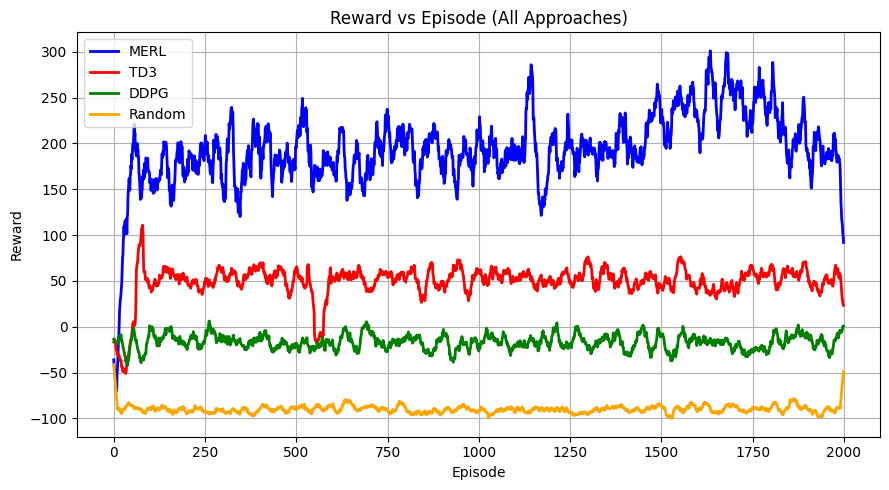

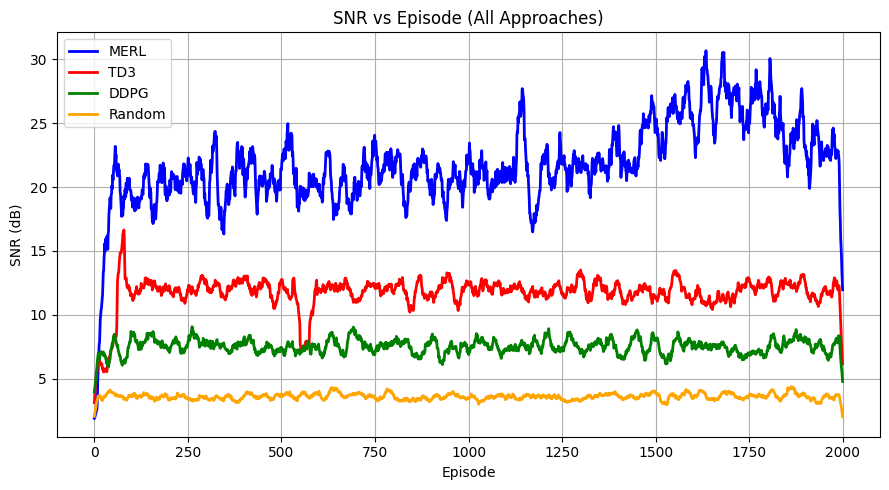

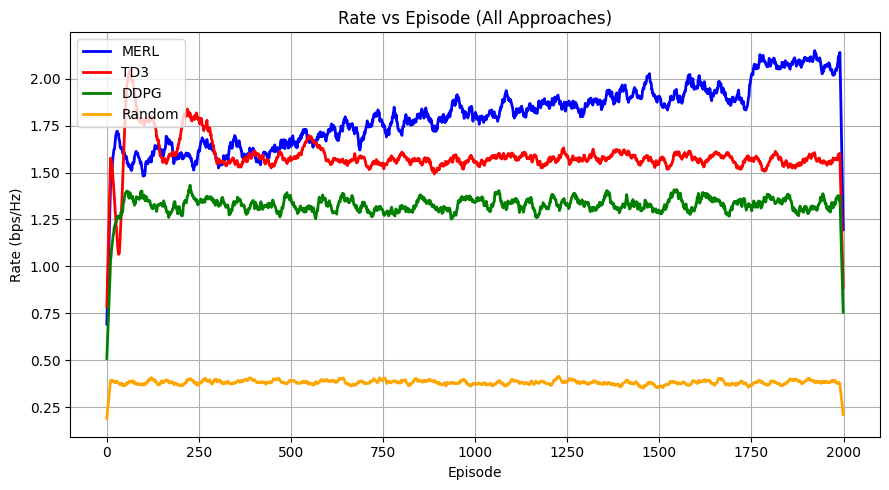

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# Helper: Smooth the curves
# -----------------------------
def smooth_curve(values, window=20):
    if window < 2:
        return values
    return np.convolve(values, np.ones(window)/window, mode='same')


# -----------------------------
# Load Excel files
# -----------------------------
files = {
    "MERL": "MERL_results.xlsx",
    "TD3": "TD3_results.xlsx",
    "DDPG": "DDPG_results.xlsx",
    "Random": "RandomBaseline_results.xlsx",
}

colors = {
    "MERL": "blue",
    "TD3": "red",
    "DDPG": "green",
    "Random": "orange",
}

# Sheets are the same for all
sheet_reward = "EpisodeReward"
sheet_snr = "EpisodeSNR"
sheet_rate = "EpisodeRate"


# =====================================
# 1️⃣ REWARD PLOT
# =====================================
plt.figure(figsize=(9, 5))

for name, filename in files.items():
    df = pd.read_excel(filename, sheet_name=sheet_reward)
    rewards = smooth_curve(df["Reward"].values)
    plt.plot(rewards, label=name, color=colors[name], linewidth=2)

plt.xlabel("Episode")
plt.ylabel("Reward")
#plt.title("Reward vs Episode (All Approaches)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# =====================================
# 2️⃣ SNR PLOT
# =====================================
plt.figure(figsize=(9, 5))

for name, filename in files.items():
    df = pd.read_excel(filename, sheet_name=sheet_snr)
    snr = smooth_curve(df["SNR"].values)
    plt.plot(snr, label=name, color=colors[name], linewidth=2)

plt.xlabel("Episode")
plt.ylabel("SNR (dB)")
#plt.title("SNR vs Episode (All Approaches)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# =====================================
# 3️⃣ RATE PLOT
# =====================================
plt.figure(figsize=(9, 5))

for name, filename in files.items():
    df = pd.read_excel(filename, sheet_name=sheet_rate)
    rate = smooth_curve(df["Rate"].values)
    plt.plot(rate, label=name, color=colors[name], linewidth=2)

plt.xlabel("Episode")
plt.ylabel("Rate (bps/Hz)")
#plt.title("Rate vs Episode (All Approaches)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# with smoothness


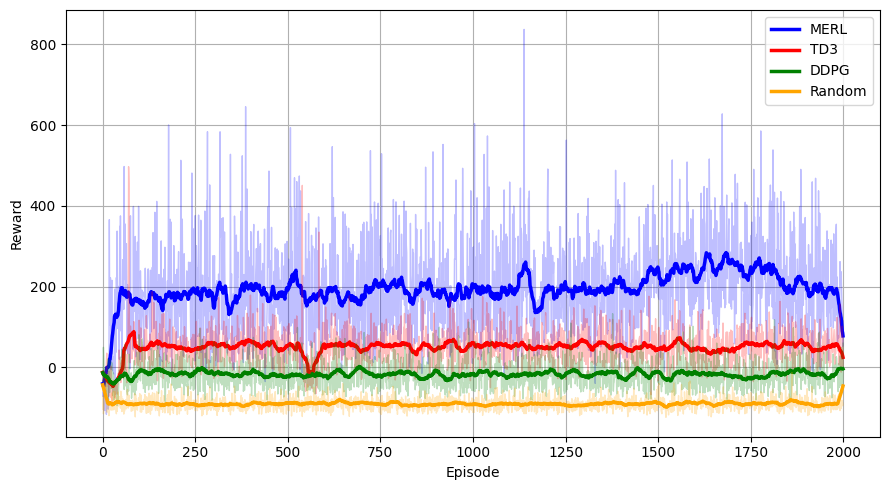

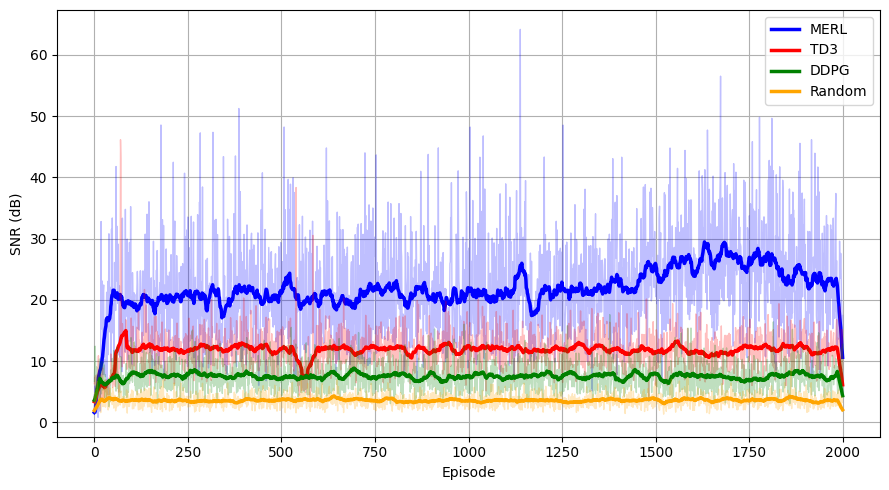

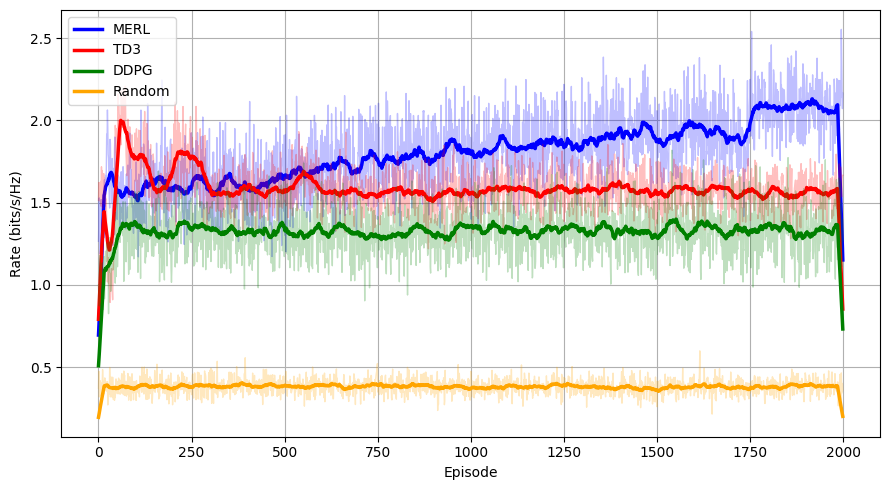

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------------------
# Helper: Smooth the curves
# ----------------------------------------
def smooth_curve(values, window=30):
    if window < 2:
        return values
    return np.convolve(values, np.ones(window)/window, mode='same')


# ----------------------------------------
# Load Excel files
# ----------------------------------------
files = {
    "MERL": "MERL_results.xlsx",
    "TD3": "TD3_results.xlsx",
    "DDPG": "DDPG_results.xlsx",
    "Random": "RandomBaseline_results.xlsx",
}

colors = {
    "MERL": "blue",
    "TD3": "red",
    "DDPG": "green",
    "Random": "orange",
}

# Excel sheet names
sheet_reward = "EpisodeReward"
sheet_snr = "EpisodeSNR"
sheet_rate = "EpisodeRate"


# ==========================================================
# 1️⃣ REWARD PLOT — SHADOWED + FITTING LINE
# ==========================================================
plt.figure(figsize=(9, 5))

for name, filename in files.items():
    df = pd.read_excel(filename, sheet_name=sheet_reward)
    raw = df["Reward"].values

    # Shadow (raw curve, light)
    plt.plot(
        raw,
        color=colors[name],
        alpha=0.25,
        linewidth=1
    )

    # Fitted / smoothed line (bold)
    smoothed = smooth_curve(raw)
    plt.plot(
        smoothed,
        color=colors[name],
        linewidth=2.5,
        label=name
    )

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# ==========================================================
# 2️⃣ SNR PLOT — SHADOW ONLY
# ==========================================================
plt.figure(figsize=(9, 5))

for name, filename in files.items():
    df = pd.read_excel(filename, sheet_name=sheet_snr)
    raw = df["SNR"].values

    # shadow
    plt.plot(
        raw,
        color=colors[name],
        alpha=0.25,
        linewidth=1
    )

    # smoothed
    smoothed = smooth_curve(raw)
    plt.plot(
        smoothed,
        color=colors[name],
        linewidth=2.5,
        label=name
    )

plt.xlabel("Episode")
plt.ylabel("SNR (dB)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# ==========================================================
# 3️⃣ RATE PLOT — SHADOW ONLY
# ==========================================================
plt.figure(figsize=(9, 5))

for name, filename in files.items():
    df = pd.read_excel(filename, sheet_name=sheet_rate)
    raw = df["Rate"].values

    # shadow
    plt.plot(
        raw,
        color=colors[name],
        alpha=0.25,
        linewidth=1
    )

    # smoothed
    smoothed = smooth_curve(raw)
    plt.plot(
        smoothed,
        color=colors[name],
        linewidth=2.5,
        label=name
    )

plt.xlabel("Episode")
plt.ylabel("Rate (bits/s/Hz)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#Running 3


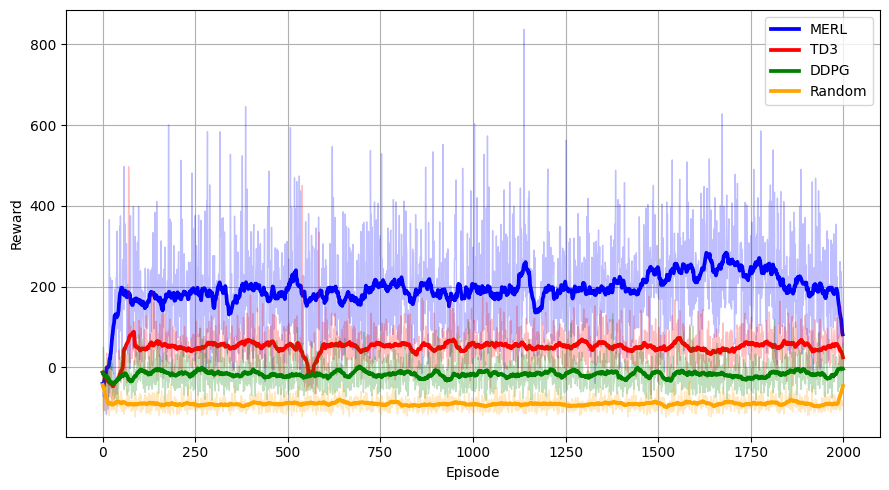

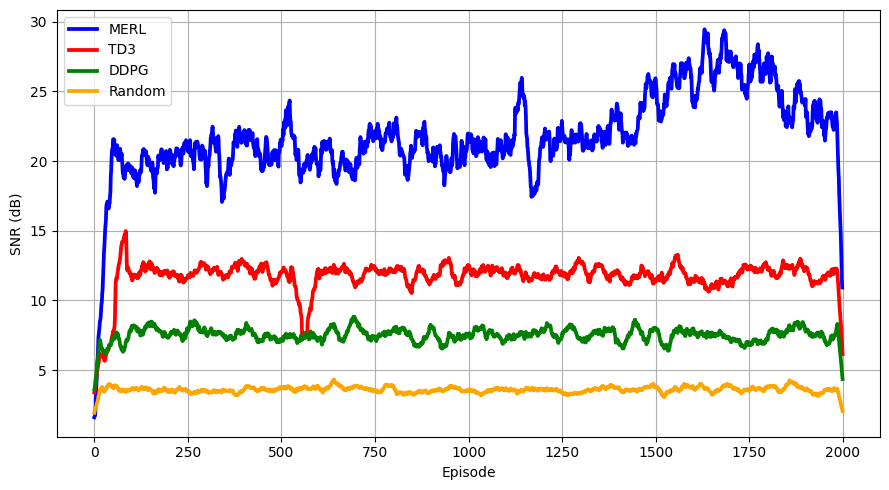

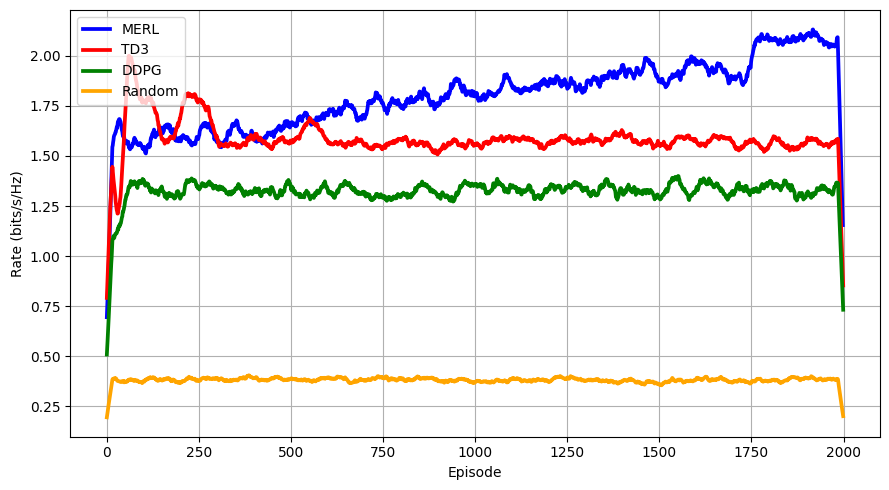

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------------------
# Helper: Smooth the curves
# ----------------------------------------
def smooth_curve(values, window=30):
    if window < 2:
        return values
    return np.convolve(values, np.ones(window)/window, mode='same')

# ----------------------------------------
# Load Excel files
# ----------------------------------------
files = {
    "MERL": "MERL_results.xlsx",
    "TD3": "TD3_results.xlsx",
    "DDPG": "DDPG_results.xlsx",
    "Random": "RandomBaseline_results.xlsx",
}

colors = {
    "MERL": "blue",
    "TD3": "red",
    "DDPG": "green",
    "Random": "orange",
}

sheet_reward = "EpisodeReward"
sheet_snr    = "EpisodeSNR"
sheet_rate   = "EpisodeRate"


# ==========================================================
# 1️⃣ REWARD PLOT — SHADOWED + FITTING LINE
# ==========================================================
plt.figure(figsize=(9, 5))

for name, filename in files.items():
    df = pd.read_excel(filename, sheet_name=sheet_reward)
    raw = df["Reward"].values

    # Shadow (light curve)
    plt.plot(
        raw,
        color=colors[name],
        alpha=0.25,
        linewidth=1
    )

    # Smooth main curve
    smoothed = smooth_curve(raw)
    plt.plot(
        smoothed,
        color=colors[name],
        linewidth=2.7,
        label=name
    )

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



# ==========================================================
# 2️⃣ SNR PLOT — NO SHADOW (ONLY SMOOTH MAIN CURVE)
# ==========================================================
plt.figure(figsize=(9, 5))

for name, filename in files.items():
    df = pd.read_excel(filename, sheet_name=sheet_snr)
    raw = df["SNR"].values

    # Smooth only — NO shadow
    smoothed = smooth_curve(raw)
    plt.plot(
        smoothed,
        color=colors[name],
        linewidth=2.7,
        label=name
    )

plt.xlabel("Episode")
plt.ylabel("SNR (dB)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



# ==========================================================
# 3️⃣ RATE PLOT — NO SHADOW (ONLY SMOOTH MAIN CURVE)
# ==========================================================
plt.figure(figsize=(9, 5))

for name, filename in files.items():
    df = pd.read_excel(filename, sheet_name=sheet_rate)
    raw = df["Rate"].values

    # Smooth only — NO shadow
    smoothed = smooth_curve(raw)
    plt.plot(
        smoothed,
        color=colors[name],
        linewidth=2.7,
        label=name
    )

plt.xlabel("Episode")
plt.ylabel("Rate (bits/s/Hz)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
